## 🧠  2. Conditional Data Imputers

### 2.1 Conditional Gaussian Imputer (Heeso)

#### 2.1.1 Implementierungsschritte

| Schritt | Beschreibung                                                                                               | Status |
|--------:|------------------------------------------------------------------------------------------------------------|------|
|   **1** | Theoretische Herleitung der bedingten Verteilung und Kovarianz (Gleichung (10), (11) aus Aas et al.)       | ✅    |
|   **2** | Umsetzung der bedingten Verteilung mit `numpy`/`scipy`, inkl. Stichprobe aus der multivariaten Normalverteilung | ✅    |
|   **3** | Integration als Klasse in die `shapiq-student`-Struktur (Vererbung von `ImputerBase`) | ☑️   |
|   **4** | Erstellung von Unit-Tests im `tests/` | ☑️     |
|   **5** | Dokumentation mit `Sphinx`| ☑️     |


### (2.2 Gaussian Copula Conditional Imputer (Alejandro))

In [15]:
import numpy as np
from scipy.stats import multivariate_normal


In [25]:
# ===========================================================
# Schritt 1: Theoretische Herleitung
# - Berechnung von Mittelwert und Kovarianzmatrix
# - Aufteilung in bekannte (gegeben) und Ziel-Features
# - Basierend auf Gleichung (10) und (11) aus Aas et al. (2021)
# ===========================================================

def sample_conditional_gaussian(data, cond_idx, cond_values, n_samples = 1, random_state = None):
  data = np.asanyarray(data)
  cond_values = np.asanyarray(cond_values)

# Gesamtmittelwert und Kovarianzmatrix berechnen
  mu = np.mean(data, axis = 0)
  sigma_full = np.cov(data, rowvar = False)

# Ziel-Features bestimmen (alle außer den bedingten)
  feature_indices = np.arange(data.shape[1])
  target_idx = np.setdiff1d(feature_indices, cond_idx, assume_unique= True)

# Mittelwert-Vektoren aufteilen
  mu_s = np.take(mu, cond_idx)       # μ_S
  mu_sbar = np.take(mu, target_idx)   # μ_{S̄}

# Kovarianz extrahieren
  sigma_ss = sigma_full[np.ix_(cond_idx, cond_idx)]                 # Σ_{SS}
  sigma_sbar_sbar = sigma_full[np.ix_(target_idx, target_idx)]      # Σ_{S̄S̄}
  sigma_sbar_s = sigma_full[np.ix_(target_idx, cond_idx)]           # Σ_{S̄S}
  sigma_s_sbar = sigma_sbar_s.T                                     # Σ_{SS̄}

# Differenzvektor zwischen bedingten Werten und Mittelwerten
  delta = cond_values - mu_s        # x*_S - μ_S
  inv_sigma_ss = np.linalg.pinv(sigma_ss)                  # Pseudoinverse von Σ_{SS}

# Bedingter Mittelwert μ_{S̄|S} (Gleichung (10) aus Aas et al.)
  mu_cond = mu_sbar + sigma_sbar_s @ inv_sigma_ss @ delta

# Bedingte Kovarianz Σ_{S̄|S} (Gleichung (11) aus Aas et al.)
  sigma_cond = sigma_sbar_sbar - sigma_sbar_s @ inv_sigma_ss @ sigma_s_sbar

# ===========================================================
# Schritt 2: Umsetzung der bedingten Verteilung
# - Stichprobe aus der multivariaten Normalverteilung
# ===========================================================

  conditional_samples = multivariate_normal(mean=mu_cond, cov=sigma_cond).rvs(size=n_samples, random_state=random_state)
  return conditional_samples, mu_cond, sigma_cond



#### 2.1.2 Zusatzvisualisierung
Diese Visualisierung ist **nicht Teil der Pflichtaufgabe**, sondern dient nur zur Veranschaulichung der bedingten Stichprobe aus der multivariaten Normalverteilung.
TBD

In [20]:
import pandas as pd
import matplotlib.pyplot as plt


In [21]:
np.random.seed(0)
mean = [0, 0, 0]
cov = [[1, 0.8, 0.5],
       [0.8, 1, 0.3],
       [0.5, 0.3, 1]]
sample_data = np.random.multivariate_normal(mean, cov, size=100)

In [22]:
cond_idx = [0]
cond_values = [0.5]
n_samples = 1000

In [23]:
samples, mu_cond, sigma_cond = sample_conditional_gaussian(
    sample_data,
    cond_idx,
    cond_values,
    n_samples=n_samples,
    random_state=123
)

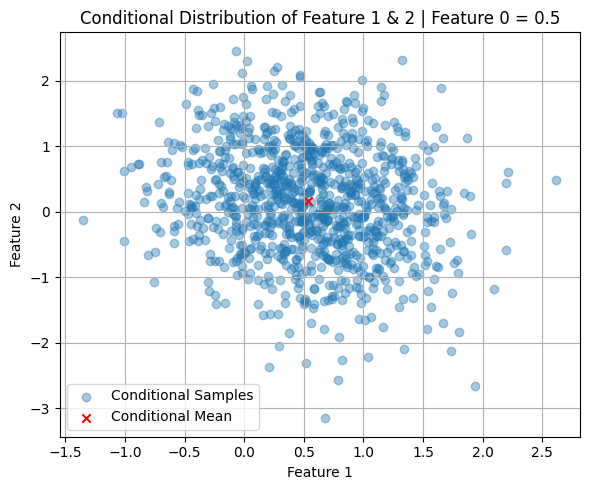

In [24]:
df = pd.DataFrame(samples, columns=["Feature 1", "Feature 2"])
plt.figure(figsize=(6, 5))
plt.scatter(df["Feature 1"], df["Feature 2"], alpha=0.4, label='Conditional Samples')
plt.scatter(mu_cond[0], mu_cond[1], color='red', label='Conditional Mean', marker='x')
plt.title("Conditional Distribution of Feature 1 & 2 | Feature 0 = 0.5")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()